In [263]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch
import pandas as pd
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)



# 1. Load data

In [264]:
fs = 100   # Sampling frequency from paper
ninapro_root = "./Ninapro/DB1"
print(os.path.abspath(ninapro_root))

ex1_file = os.path.join(ninapro_root, "S2_A1_E1.mat")
data = loadmat(ex1_file)

print(data.keys())  # Inspect available keys

# Ninapro EMG data is stored under key 'emg'
emg = data['emg']

data_shape = emg.shape
n_timepoints = emg.shape[0]
n_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {n_timepoints} timepoints.')
print(f'There are {n_channels} channels.')   # Each channel = a single EMG electrode on the participant


/Users/colineleteurtre/Desktop/cours/NSSP/NSSP_project2_groupK/Ninapro/DB1
dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])
The shape of the data is (100686, 10)
There are 100686 timepoints.
There are 10 channels.


# 2. Visualization and Preprocessing

## 2.1. Visualize signals and understand the dataset

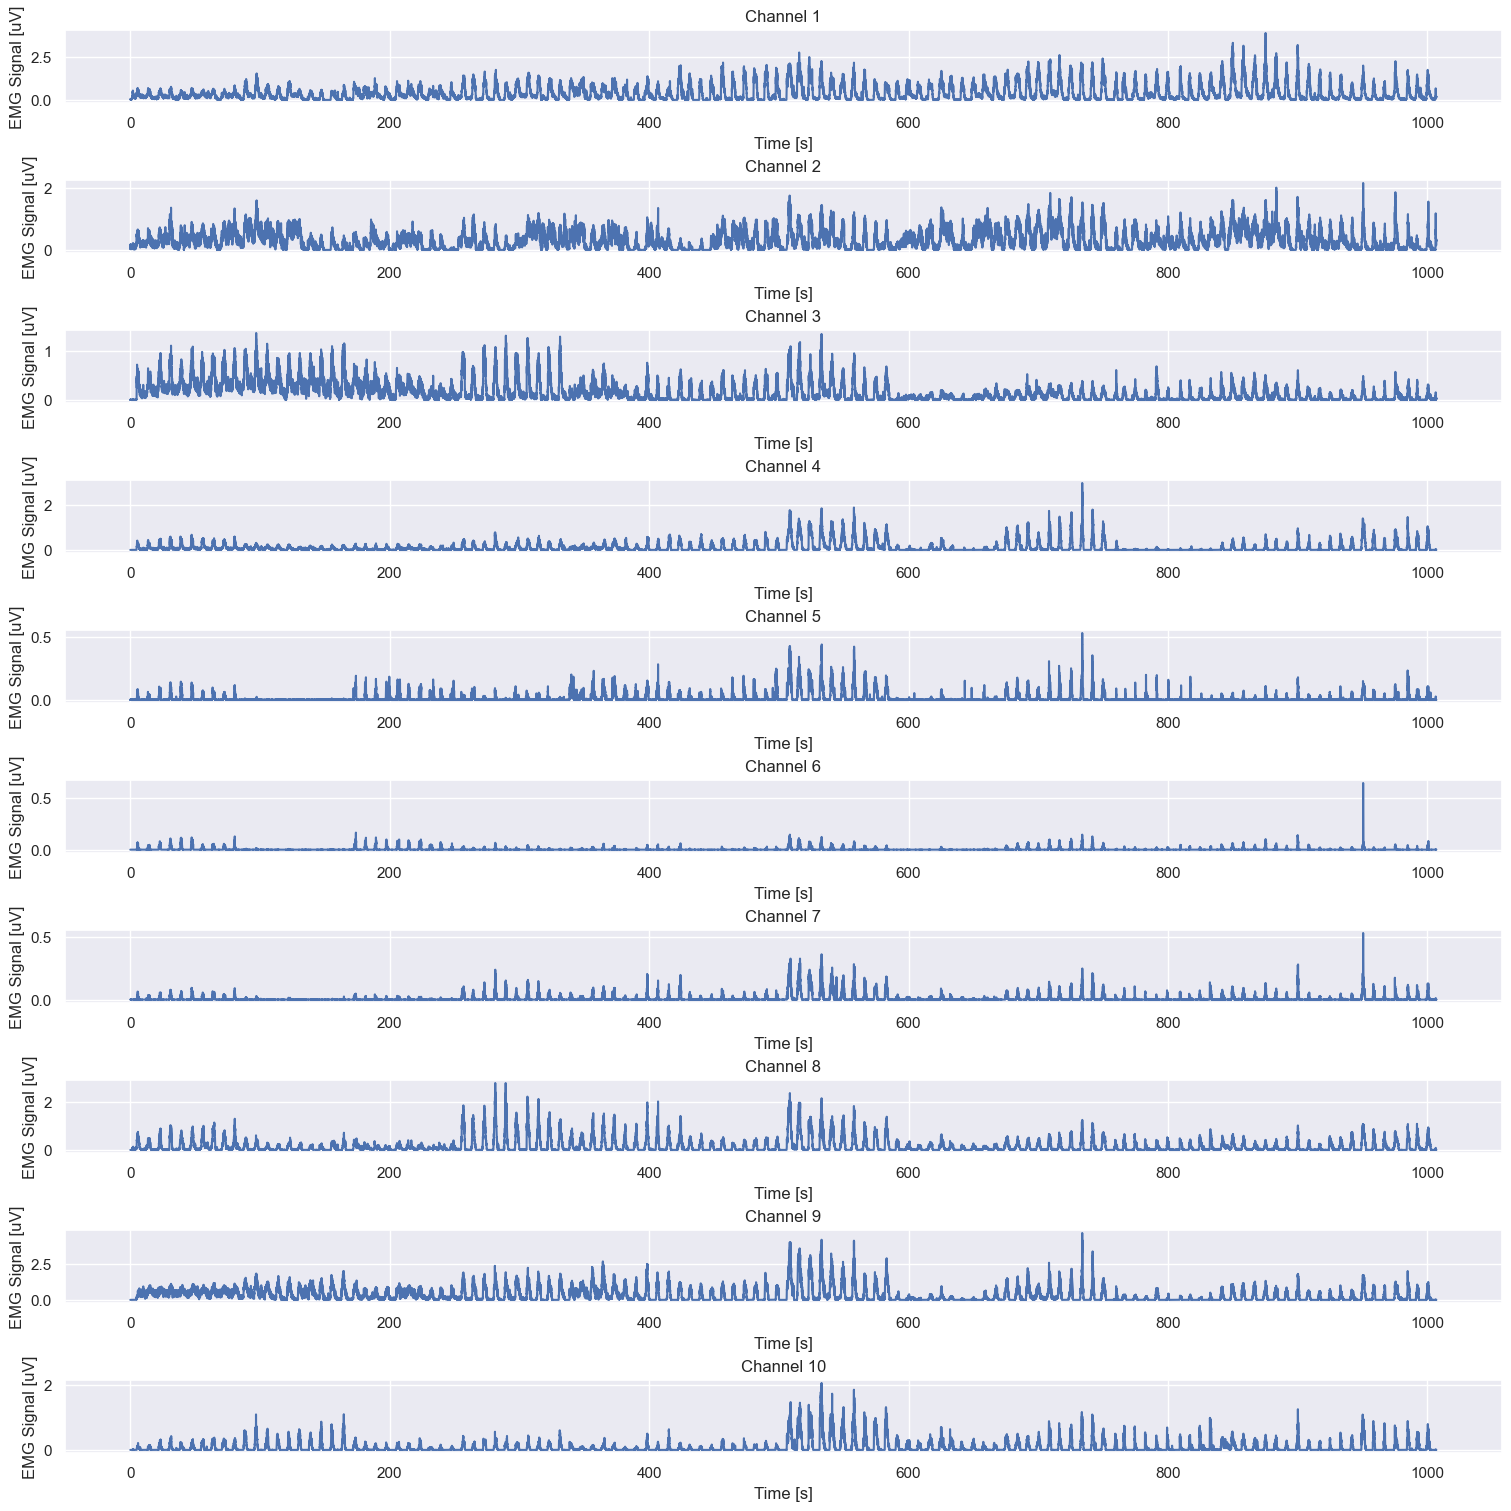

In [265]:
n_channels = emg.shape[1]
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")
fig.savefig("plots/emg_channels_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

In [266]:
# Data is already partly preprocessed!

emg_rectified = data["emg"].copy()

# Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
stimulus = data["restimulus"] 
repetition = data["rerepetition"] 

print(f'What is the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What is the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


Stimulus is the type of movement that is being performed.

Repetition is the number of times the movement has been repeated.



In [267]:
# Overview of the dataset

random_indices = np.random.choice(emg.shape[0], size=10, replace=False)

emg_random = emg[random_indices, :]
stimulus_random = stimulus[random_indices, 0]
repetition_random = repetition[random_indices, 0]

df_random = pd.DataFrame(emg_random, columns=[f"Ch{c+1}" for c in range(emg.shape[1])])
df_random["Stimulus"] = stimulus_random
df_random["Repetition"] = repetition_random

print(df_random)

      Ch1     Ch2     Ch3     Ch4     Ch5     Ch6     Ch7     Ch8     Ch9  \
0  0.5786  0.1880  0.1929  0.0732  0.0146  0.0024  0.0024  0.2002  0.1929   
1  0.0439  0.0024  0.0635  0.0098  0.0024  0.0024  0.0024  0.0195  0.1221   
2  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024   
3  0.7251  0.4980  0.4199  0.1489  0.1123  0.0244  0.0708  1.1133  1.7725   
4  0.1807  0.3052  0.0415  0.0024  0.0024  0.0024  0.0024  0.0049  0.0024   
5  0.0366  0.0977  0.0415  0.2344  0.0098  0.0024  0.0024  0.0024  0.3442   
6  0.2100  0.5615  0.1904  0.0073  0.0024  0.0024  0.0024  0.0122  0.0171   
7  0.7495  0.4053  0.4907  0.2319  0.1025  0.0757  0.0195  0.1367  0.8472   
8  0.0049  0.0854  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024  0.0024   
9  0.2222  0.5664  0.3076  0.0537  0.0024  0.0024  0.0024  0.0122  0.2490   

     Ch10  Stimulus  Repetition  
0  0.0244         5           3  
1  0.0024         0           0  
2  0.0024         0           0  
3  0.1099       

In [268]:
# Count of stimuli and repetitions

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1            # Number of type of movements repeated by the subject
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1      # Number of times each movement is repeated
n_channels = emg_rectified.shape[1]         

print(f'How many types of movement are there? {n_stimuli}')
print(f'How many repetitions are there? {n_repetitions}')   

How many types of movement are there? 12
How many repetitions are there? 10


In [269]:
# Number of samples across trials

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1) 
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

1 trial is a combination of 1 stimulus and 1 repetition, and regroup all the timepoints during which the stimulus is being done at the exact repetition.

We have a matrix of 12 x 10 trials as the matrix is a combination of 12 stimuli repeated 10 times = 120 different possibilites.


## 2.2. Visualize a single trial

In [270]:
# Define the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initialize the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

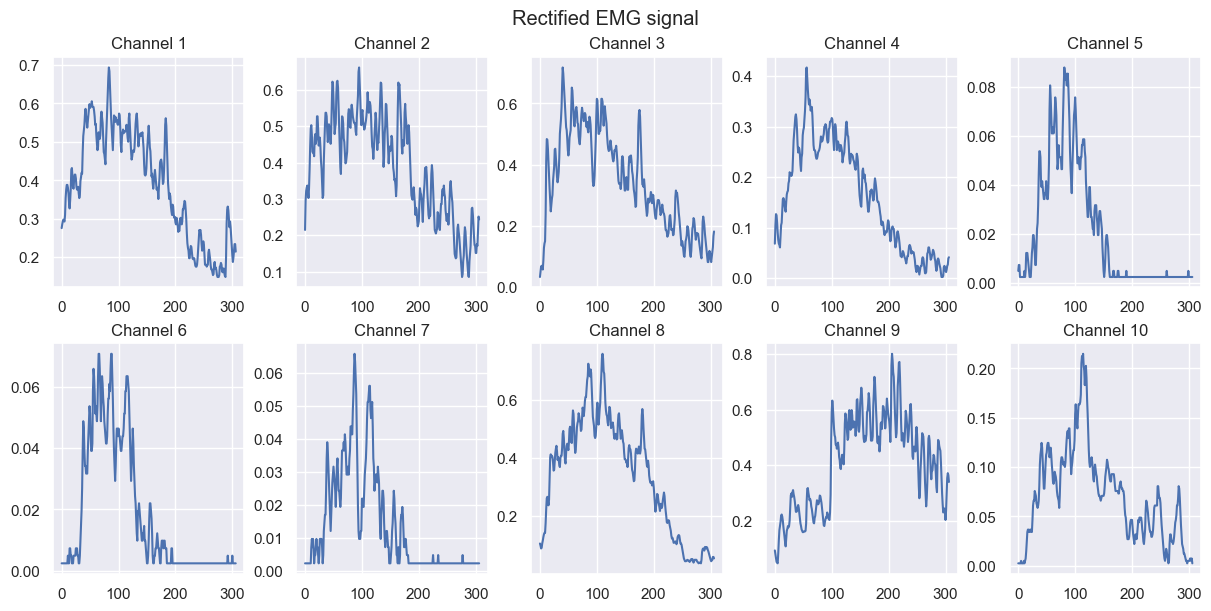

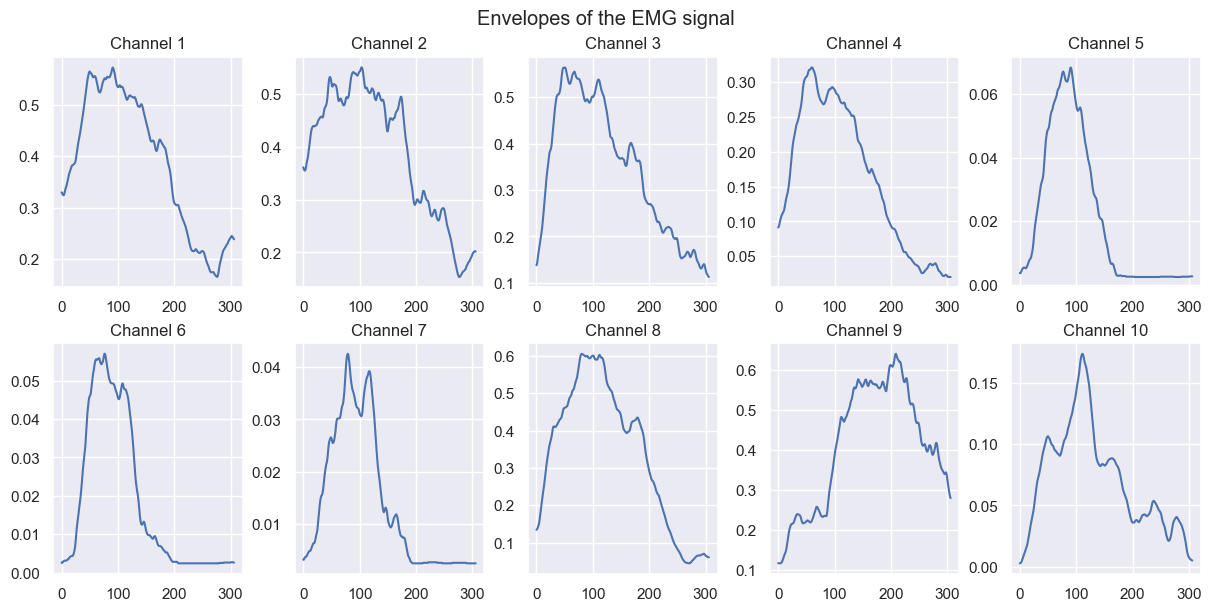

In [271]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]

# Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")
fig.savefig("plots/emg_channels_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")
fig.savefig("plots/emg_envelopes1.png", dpi=300, bbox_inches="tight")
plt.show()


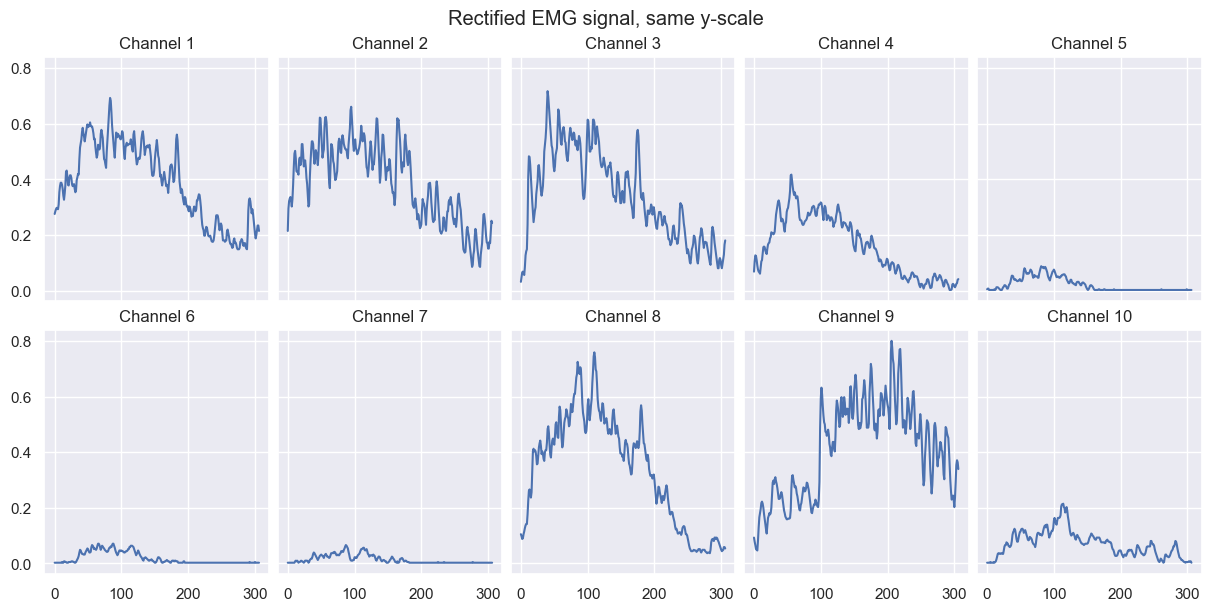

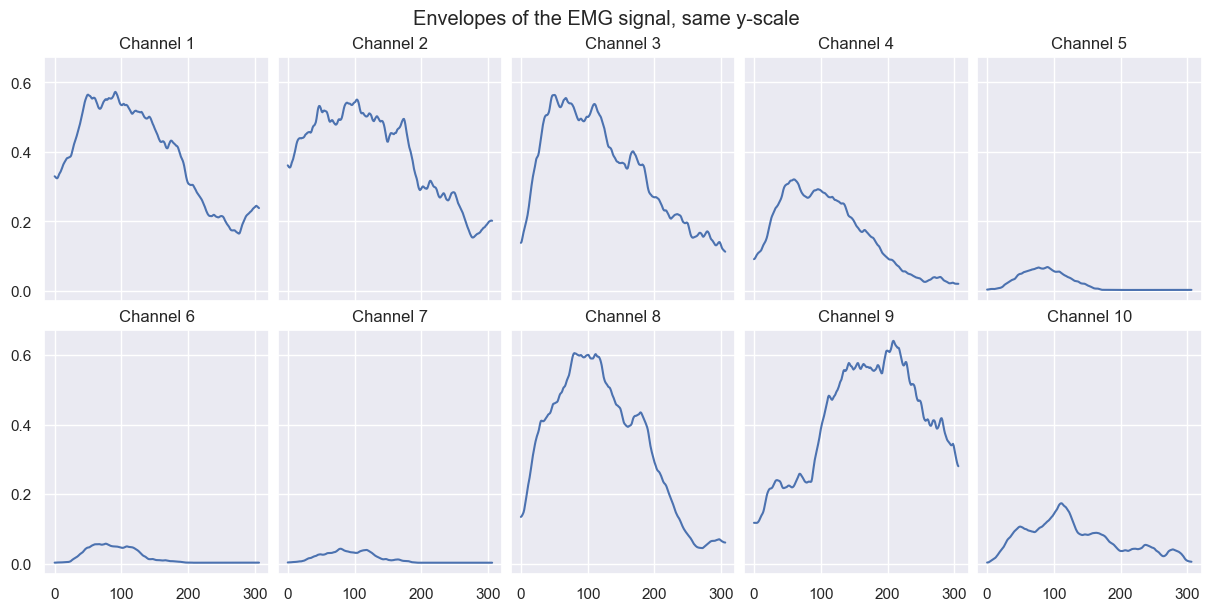

In [272]:
# Now we plot all the channels on the same y-scale

fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]

# Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal, same y-scale")
fig.savefig("plots/emg_rectified2.png", dpi=300, bbox_inches="tight")

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal, same y-scale")
fig.savefig("plots/emg_envelopes2.png", dpi=300, bbox_inches="tight")
plt.show()


## 2.3. Visualize all the trials

In [273]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)   # Mean across time for each channel

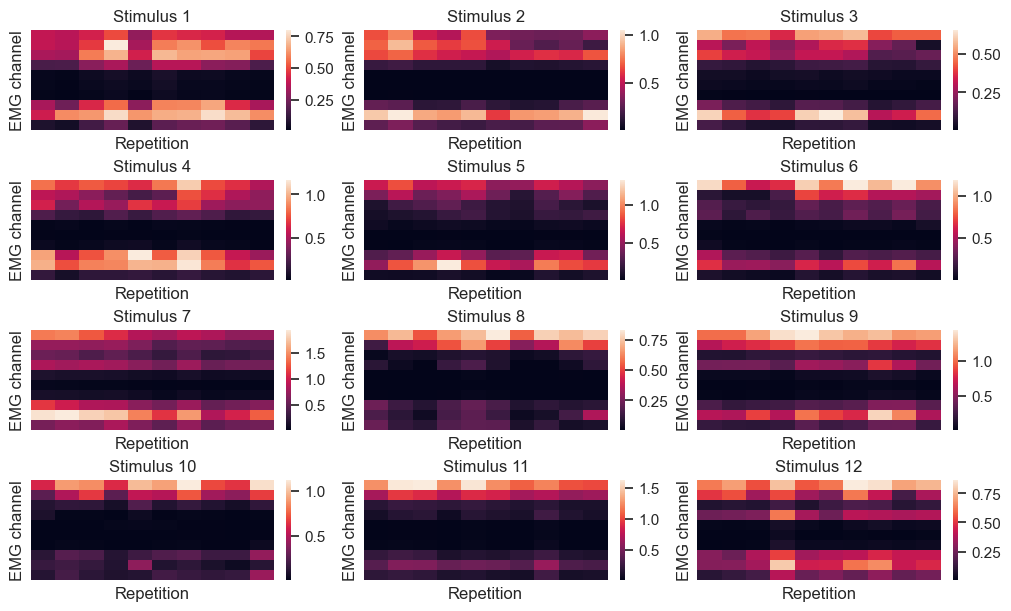

In [274]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

fig.savefig("plots/emg_heatmaps.png", dpi=300, bbox_inches="tight")
plt.show()

# 3. Split data and extract features

## 3.1. Build dataset and extract features

In [275]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1

    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]

    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):

            # Assign the label for the current sample
            labels[current_sample_index] = i + 1

            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0

            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:

                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)

                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [ ]:
# Mean Absolute Value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis = 0) 

# Maximum Absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0) 

# Root Mean Qquare (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform Length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope Sign Changes (SSC)
ssc = lambda x: np.sum(((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) > 0),axis=0)

dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")

Dataset dimension: (120, 60)
Labels dimension: (120,)


## 3.2. Visualize all features across trials

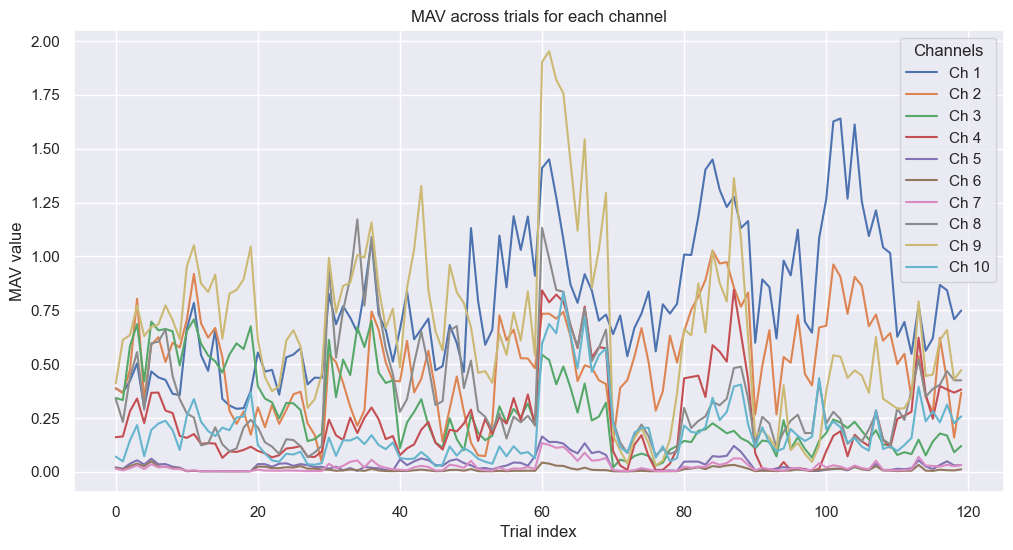

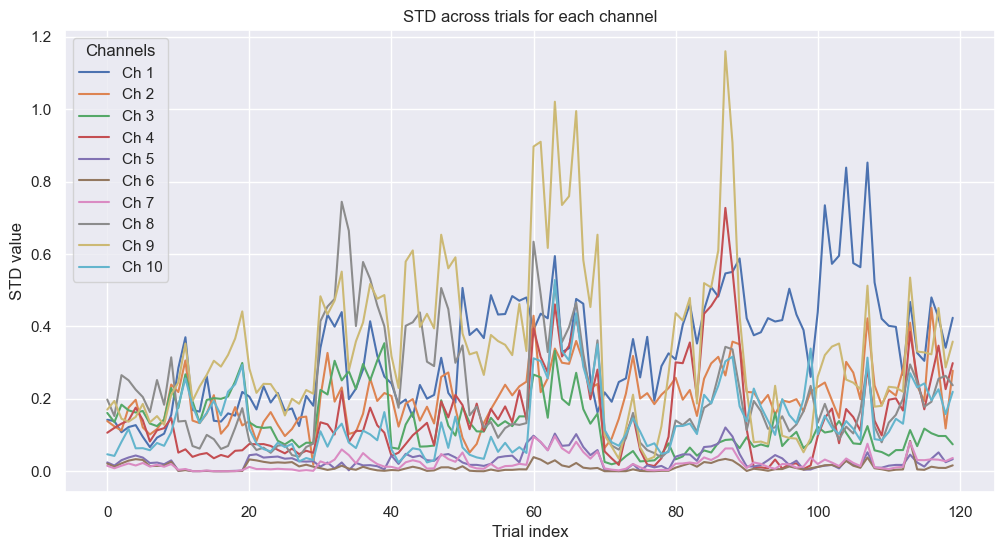

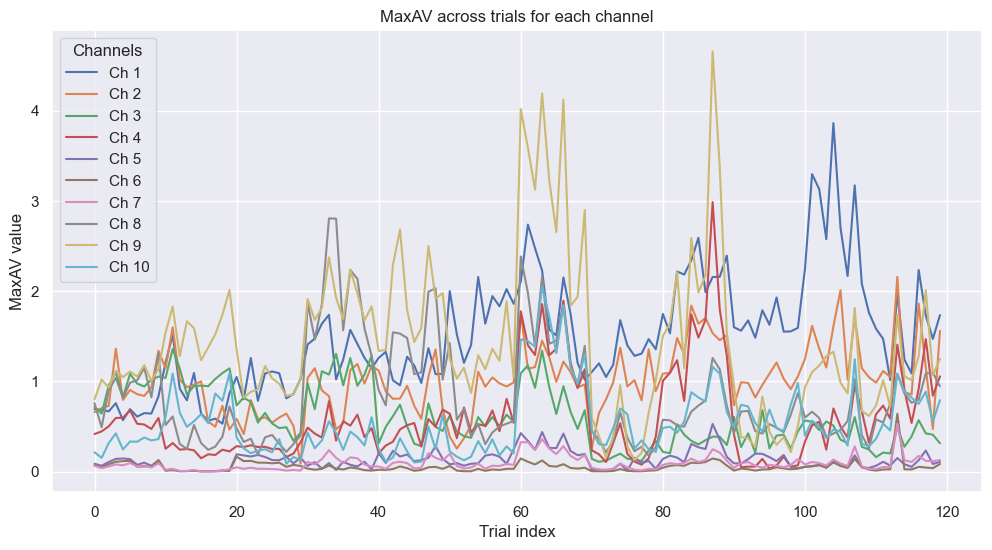

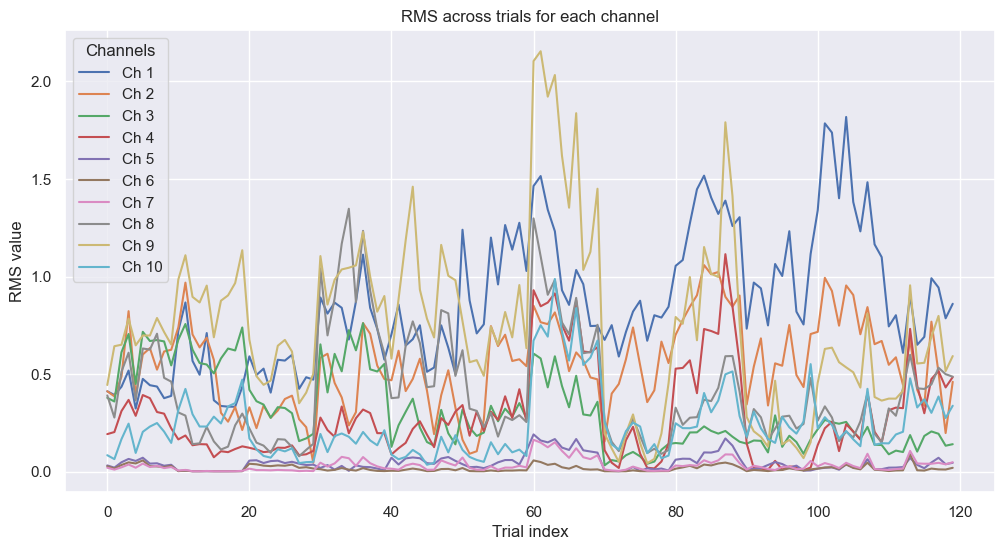

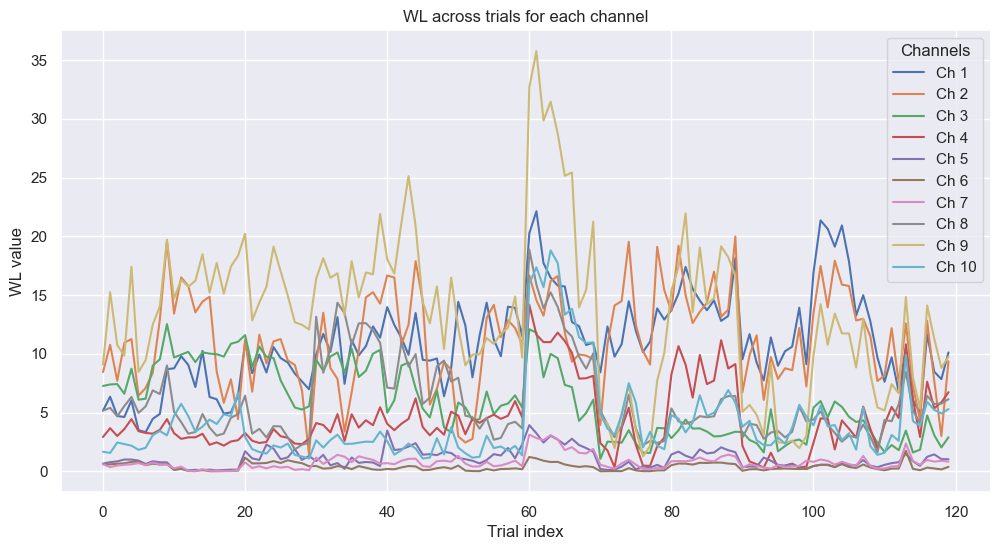

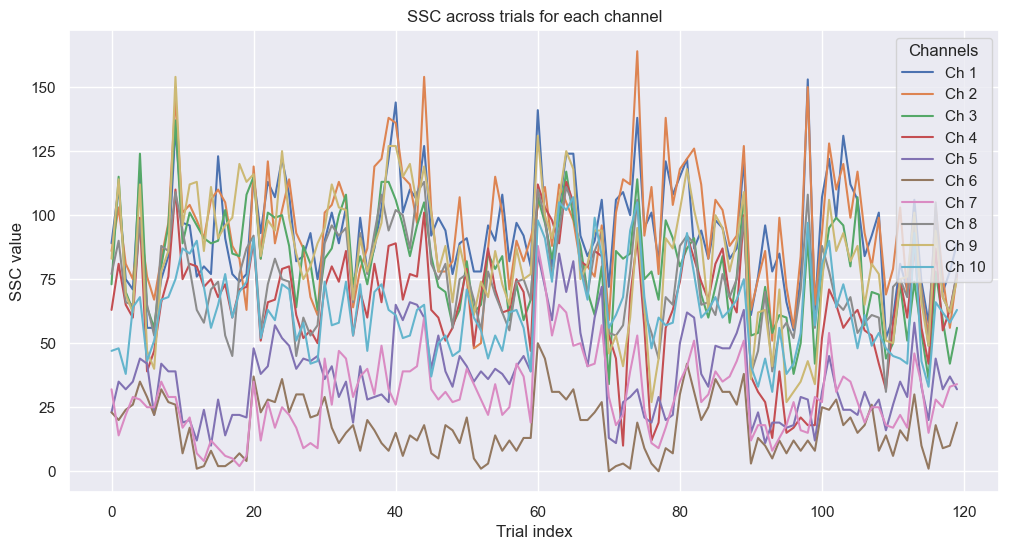

In [277]:
feature_names = ['MAV','STD','MaxAV','RMS','WL','SSC']
n_features = len(feature_names)

for k in range (n_features):
    plt.figure(figsize=(12,6))
    for ch in range(n_channels):
        plt.plot(dataset[:,ch + n_repetitions*k], label=f"Ch {ch+1}")
    plt.xlabel("Trial index")
    plt.ylabel(f"{feature_names[k]} value")
    plt.title(f"{feature_names[k]} across trials for each channel")
    plt.legend(title = 'Channels')
    plt.savefig(f'plots/plots_{feature_names[k]}_across_trials.png', dpi=300, bbox_inches='tight')
    plt.show()


## 3.3. Split data

In [278]:
# 80% training set, 20% testing set
seed = 41
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify = labels, random_state=seed) 

## 3.4. Normalize data

In [279]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Classification

## 4.1. Baseline model

In [280]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

y_pred_baseline = rf.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

print("Baseline test accuracy:", accuracy_baseline)

Baseline test accuracy: 0.8333333333333334


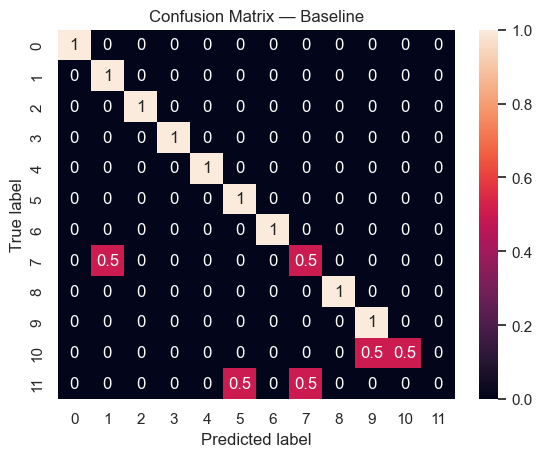

In [281]:
confmat_baseline = confusion_matrix(y_test, y_pred_baseline, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat_baseline, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — Baseline")
fig.savefig("plots/confusion_matrix_baseline.png", dpi=300, bbox_inches="tight")
plt.show()

## 4.2. Hyperparameter optimization

In [282]:
param_grid = {
    "n_estimators": [40, 50, 60, 100, 150, 200],
    "max_depth": [4, 5, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["log2", "sqrt"]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=seed),
    param_grid=param_grid,
    cv=5,                 # 5-fold cross validation, meaning that the validation sets will be 80% / 5 = 16% of the whole dataset
    scoring="accuracy"   # Optimize accuracy
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("\nBest CV Training accuracy:", grid.best_score_)


Best parameters: {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}

Best CV Training accuracy: 0.9163157894736841


In [288]:
best_rf = grid.best_estimator_
y_pred_cv = best_rf.predict(X_test)
accuracy_cv = accuracy_score(y_test, y_pred_cv)

print("Train accuracy:", grid.best_score_)
print("Test accuracy:", accuracy_cv)

Train accuracy: 0.9163157894736841
Test accuracy: 0.9166666666666666


In [289]:
print(y_pred_cv)
print(y_test)
np.where(y_pred_cv != y_test)

[ 7.  2.  9.  7.  6.  5. 10. 12.  4.  3.  3. 10. 11.  8.  2.  1.  8.  5.
  4.  1.  9.  6.  8. 10.]
[ 7.  2.  9.  7.  6.  5. 10. 12.  4.  3.  3. 11. 11.  8.  2.  1. 12.  5.
  4.  1.  9.  6.  8. 10.]


(array([11, 16]),)

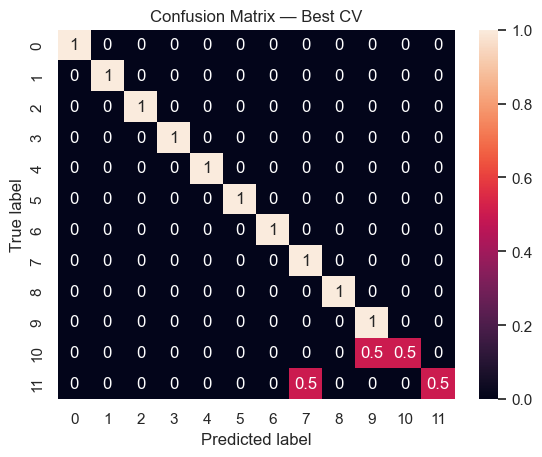

In [290]:
confmat_cv = confusion_matrix(y_test, y_pred_cv, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat_cv, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — Best CV")
fig.savefig("plots/confusion_matrix_cv.png", dpi=300, bbox_inches="tight")
plt.show()

# 5. Feature selection

## 5.1. SelectKBest with Mutual information

Estimated mutual information between each feature and the target:
[0.66827061 0.43096873 0.92620133 1.06374733 0.89994472 0.61594659
 0.75654002 0.75345876 0.94259496 0.63640617 0.76627008 0.34527733
 0.8142575  0.8797407  0.67797355 0.62062394 0.781571   0.84933258
 0.98527697 0.65495463 0.82853895 0.44055348 0.73073374 0.92120512
 0.61520122 0.59819978 0.70115467 0.81886041 0.85465141 0.77679601
 0.74325435 0.46792884 0.97875384 1.04759562 0.77270764 0.62337974
 0.78690422 0.79922151 1.01786551 0.66294545 0.55630352 0.19820372
 0.82509038 0.96812524 0.96974853 0.80935558 0.70562808 0.77810822
 0.72367667 0.63014987 0.17377505 0.12729025 0.24416199 0.41860659
 0.72019685 0.5461657  0.49489457 0.1983283  0.36304565 0.16311916]

Test accuracy with SelectKBest with Mutual information feature selection: 0.875


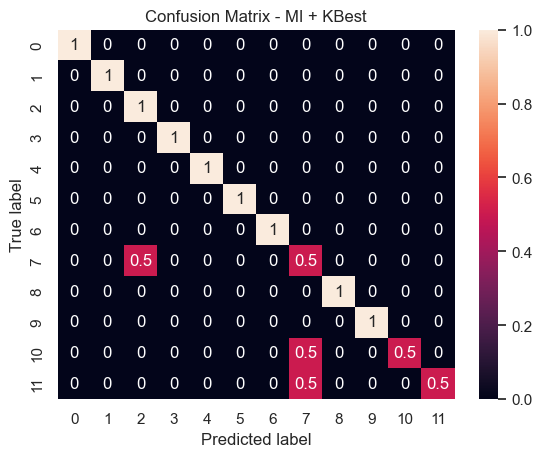

In [291]:
# Calculate mutual information between each feature and the target variable
mutual_info = mutual_info_classif(X_train, y_train)
print(f"Estimated mutual information between each feature and the target:\n{mutual_info}\n")

# Select the top 30 features based on mutual information scores
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train, y_train)

# Transform the datasets to only include the selected features
X_train_best = k_best.transform(X_train)
X_test_best = k_best.transform(X_test)

# Train a Random Forest using the best parameters from GridSearch
rff = RandomForestClassifier(**grid.best_params_, random_state=42)
rff.fit(X_train_best, y_train)

# Predict labels for the test set
y_pred = rff.predict(X_test_best)

# Evaluate performance: Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with SelectKBest with Mutual information feature selection: {accuracy}")

# Confusion matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix - MI + KBest")
fig.savefig("plots/confusion_matrix_MI_KBest.png", dpi=300, bbox_inches="tight")
plt.show()


## 5.2. PCA

PCA reduced dimensionality from 60 to 11 components.
Test accuracy with PCA: 0.9166666666666666


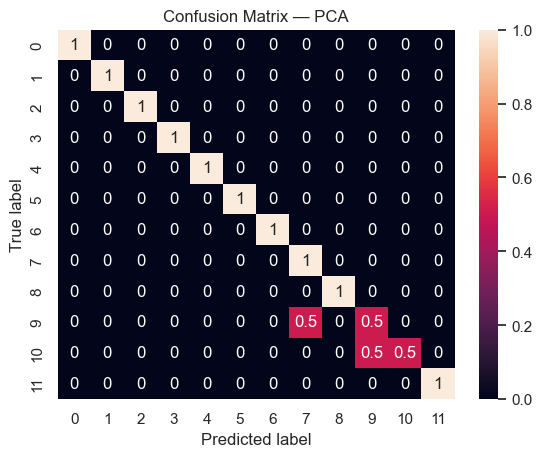

In [292]:
# Keep enough components to explain ~95% variance
pca = PCA(n_components=0.95)  
pca.fit(X_train)

# Transform the data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"PCA reduced dimensionality from {X_train.shape[1]} to {X_train_pca.shape[1]} components.")

# Train Random Forest using PCA features
clf_pca = RandomForestClassifier(**grid.best_params_)
clf_pca.fit(X_train_pca, y_train)

# Predict labels
y_pred_pca = clf_pca.predict(X_test_pca)

# Evaluate performance: Accuracy
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Test accuracy with PCA: {accuracy_pca}")

# Confusion matrix
confmat2 = confusion_matrix(y_test, y_pred_pca, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat2, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — PCA")
fig.savefig("plots/confusion_matrix_PCA.png", dpi=300, bbox_inches="tight")
plt.show()
